In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("darkgrid")

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import RobustScaler


train = pd.read_csv("/kaggle/input/ventilator-pressure-prediction/train.csv", index_col=[0])
test = pd.read_csv("/kaggle/input/ventilator-pressure-prediction/test.csv", index_col=[0])

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [3]:
train.shape
print(train.columns)
feature_cols = ["R","C", "u_in", "u_out"]

RS = RobustScaler()
train[feature_cols] = RS.fit_transform(train[feature_cols])
test[feature_cols] = RS.transform(test[feature_cols])

Index(['breath_id', 'R', 'C', 'time_step', 'u_in', 'u_out', 'pressure'], dtype='object')


In [4]:
n_steps = 80
n_features = len(feature_cols)
target_column_name = 'pressure'  # Replace with the actual target column name

# Assuming "train" is a DataFrame containing your training data
n_samples_train = len(train) // n_steps  # Calculate the number of breaths
y_train = train[target_column_name].values[:n_samples_train * n_steps].reshape(-1, n_steps)
X_train = train[feature_cols].values[:n_samples_train * n_steps].reshape(-1, n_steps, n_features)

print(X_train.shape, y_train.shape)

(75450, 80, 4) (75450, 80)


# The Model

In [5]:
def get_model():
    act = "gelu"
    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=(n_steps,n_features)),
        layers.Bidirectional(layers.LSTM(150, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(150, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(150, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(150, return_sequences=True)),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation=act),
        layers.Dense(256, activation=act),
        layers.Dense(512, activation=act),
        layers.Dense(80)
    ])
    return model
with strategy.scope():
    model = get_model()
    model.compile(optimizer="adam", loss="mae")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 80, 300)          186000    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 80, 300)          541200    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 80, 300)          541200    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 80, 300)          541200    
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 80, 300)           0

In [6]:
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=1e4, decay_rate=1e-5)
cb_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
cb_es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=512, callbacks=[cb_es, cb_lr])

Epoch 1/200
118/118 [==============================] - 48s 245ms/step - loss: 2.1178 - val_loss: 1.1942 - lr: 0.0010
Epoch 2/200
118/118 [==============================] - 27s 226ms/step - loss: 1.1214 - val_loss: 0.9681 - lr: 9.9885e-04
Epoch 3/200
118/118 [==============================] - 27s 228ms/step - loss: 0.9220 - val_loss: 0.8536 - lr: 9.9770e-04
Epoch 4/200
118/118 [==============================] - 27s 230ms/step - loss: 0.8661 - val_loss: 0.8349 - lr: 9.9655e-04
Epoch 5/200
118/118 [==============================] - 27s 232ms/step - loss: 0.7890 - val_loss: 0.7178 - lr: 9.9541e-04
Epoch 6/200
118/118 [==============================] - 28s 234ms/step - loss: 0.7178 - val_loss: 0.7103 - lr: 9.9426e-04
Epoch 7/200
118/118 [==============================] - 28s 235ms/step - loss: 0.6906 - val_loss: 0.6411 - lr: 9.9312e-04
Epoch 8/200
118/118 [==============================] - 28s 236ms/step - loss: 0.6586 - val_loss: 0.6548 - lr: 9.9197e-04
Epoch 9/200
118/118 [===============

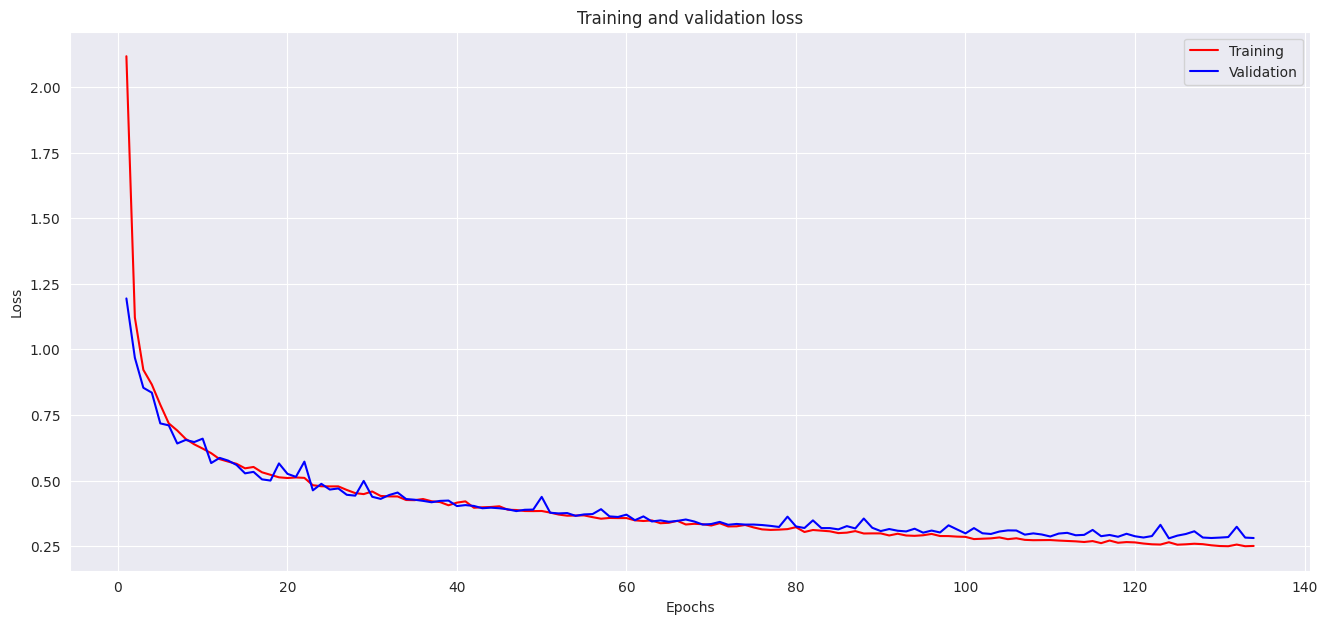

In [7]:
plt.figure(figsize=(16,7))
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(loss)+1)

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.legend(["Training", "Validation" ])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and validation loss')

plt.show()

1/1 [==============================] - 3s 3s/step


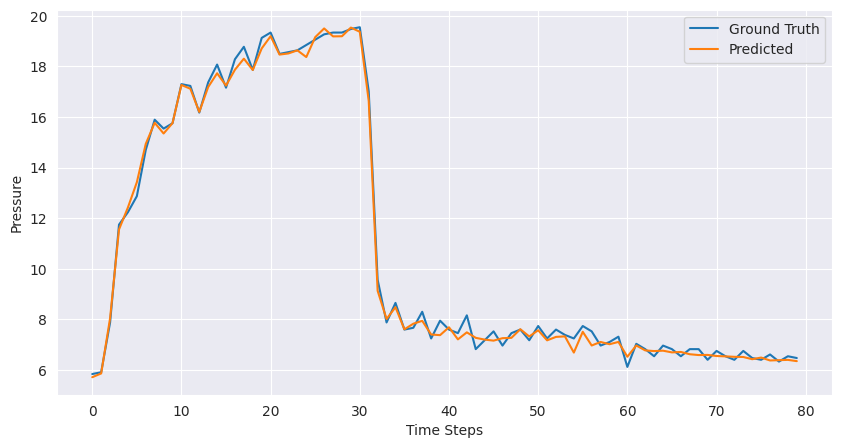

In [8]:
idx = 1
df_plot = train[train['breath_id'] == idx]
p = model.predict(df_plot[feature_cols].values.reshape(-1, n_steps, n_features))
x = range(len(df_plot))  # Use the length of df_plot for x values
y = df_plot['pressure']

plt.figure(figsize=(10, 5))
sns.lineplot(x=x, y=y, label="Ground Truth")
sns.lineplot(x=x, y=p.reshape(-1), label="Predicted")
plt.legend()
plt.ylabel("Pressure")
plt.xlabel("Time Steps")
plt.show()